# Import necessary library


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Data gathering


In [ ]:
# Load the dataset
file_path = 'retail_price.csv'
description_path = 'desciption.txt'

# Load data
data = pd.read_csv(file_path)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday              

In [ ]:
# Display basic information
print("Dataset Info:")
print(data.info())

# Display the first few rows
print("\nFirst Few Rows:")
print(data.head())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Basic statistics
print("\nSummary Statistics:")
print(data.describe())

# Data Preprocessing

In [ ]:
# Fill missing values with median for numerical columns
num_columns = data.select_dtypes(include=np.number).columns
data[num_columns] = data[num_columns].fillna(data[num_columns].median())

# Fill missing values with "Unknown" for categorical columns
cat_columns = data.select_dtypes(include="object").columns
data[cat_columns] = data[cat_columns].fillna("Unknown")

# Convert 'month_year' to datetime and extract features
data['month_year'] = pd.to_datetime(data['month_year'], format='%d-%m-%Y')
data['month'] = data['month_year'].dt.month
data['year'] = data['month_year'].dt.year
data['day'] = data['month_year'].dt.day

# 'month_year' is dropped after extracting features as it might be redundant
data = data.drop(columns=['month_year'])


Cleaned Dataset:
  product_id product_category_name  qty  total_price  freight_price  \
0       bed1        bed_bath_table    1        45.95      15.100000   
1       bed1        bed_bath_table    3       137.85      12.933333   
2       bed1        bed_bath_table    6       275.70      14.840000   
3       bed1        bed_bath_table    4       183.80      14.287500   
4       bed1        bed_bath_table    2        91.90      15.100000   

   unit_price  product_name_lenght  product_description_lenght  \
0       45.95                   39                         161   
1       45.95                   39                         161   
2       45.95                   39                         161   
3       45.95                   39                         161   
4       45.95                   39                         161   

   product_photos_qty  product_weight_g  ...  ps1        fp1      comp_2  ps2  \
0                   2               350  ...  3.9  15.011897  215.000000  4.4

In [ ]:
# Check the cleaned dataset
print("\nCleaned Dataset:")
print(data.head())

# Ensure the target variable is not null
if data['lag_price'].isnull().any():
    print("Warning: Target variable 'lag_price' has missing values!")
else:
    print("Target variable 'lag_price' is clean.")

# Save the cleaned data for further use
cleaned_data_path = 'cleaned_retail_price.csv'
data.to_csv(cleaned_data_path, index=False)
print(f"\nCleaned data saved to {cleaned_data_path}")

# Advanced Feature Engineering


In [ ]:
# Interaction Features
data['price_per_gram'] = data['unit_price'] / data['product_weight_g']
data['freight_per_unit'] = data['freight_price'] / (data['qty'] + 1e-5)

# Sales-related Ratios
data['price_to_total'] = data['unit_price'] / (data['total_price'] + 1e-5)
data['qty_to_weight'] = data['qty'] / (data['product_weight_g'] + 1e-5)

# Competitor Comparison
data['comp_1_diff'] = data['unit_price'] - data['comp_1']
data['comp_2_diff'] = data['unit_price'] - data['comp_2']
data['comp_3_diff'] = data['unit_price'] - data['comp_3']

# Competitor Scores Weighted by Price
data['comp_1_score_weighted'] = data['ps1'] / (data['comp_1'] + 1e-5)
data['comp_2_score_weighted'] = data['ps2'] / (data['comp_2'] + 1e-5)
data['comp_3_score_weighted'] = data['ps3'] / (data['comp_3'] + 1e-5)

# Temporal Features
data['is_weekend'] = ((data['weekday'] == 0) & (data['weekend'] > 0)).astype(int)
data['is_holiday'] = (data['holiday'] > 0).astype(int)

# Product-Specific Features
data['name_desc_ratio'] = data['product_name_lenght'] / (data['product_description_lenght'] + 1e-5)
data['photos_per_unit'] = data['product_photos_qty'] / (data['qty'] + 1e-5)

# Log Transformations for Skewed Features
skewed_features = ['qty', 'total_price', 'freight_price', 'product_weight_g', 's', 'volume']
for feature in skewed_features:
    data[f'log_{feature}'] = np.log1p(data[feature])

# Drop Columns with High Collinearity
columns_to_drop = ['unit_price']  # Avoid dependency on unit_price
data = data.drop(columns=columns_to_drop, errors='ignore')

# Check the new features
print("\nFeature-Engineered Dataset:")
print(data.head())

# Save the feature-engineered dataset
feature_engineered_path = 'feature_engineered_retail_price.csv'
data.to_csv(feature_engineered_path, index=False)
print(f"\nFeature-engineered data saved to {feature_engineered_path}")


Feature-Engineered Dataset:
  product_id product_category_name  qty  total_price  freight_price  \
0       bed1        bed_bath_table    1        45.95      15.100000   
1       bed1        bed_bath_table    3       137.85      12.933333   
2       bed1        bed_bath_table    6       275.70      14.840000   
3       bed1        bed_bath_table    4       183.80      14.287500   
4       bed1        bed_bath_table    2        91.90      15.100000   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                   39                         161                   2   
1                   39                         161                   2   
2                   39                         161                   2   
3                   39                         161                   2   
4                   39                         161                   2   

   product_weight_g  product_score  ...  is_weekend  is_holiday  \
0               350            4

# Split data into  Train - Test -Validation

In [ ]:
# Separate the target variable and features
X = data.drop(columns=['lag_price'])  # Features
y = data['lag_price']  # Target

# Sort data by year and month to preserve temporal order
data = data.sort_values(by=['year', 'month', 'day']).reset_index(drop=True)

# Split data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Display the shape of the datasets
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

# Save the splits for reference
train_data_path = 'train_data.csv'
val_data_path = 'val_data.csv'
test_data_path = 'test_data.csv'

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(train_data_path, index=False)
val_data.to_csv(val_data_path, index=False)
test_data.to_csv(test_data_path, index=False)

print(f"\nTraining data saved to {train_data_path}")
print(f"Validation data saved to {val_data_path}")
print(f"Test data saved to {test_data_path}")

Training Data Shape: (405, 48)
Validation Data Shape: (135, 48)
Test Data Shape: (136, 48)

Training data saved to train_data.csv
Validation data saved to val_data.csv
Test data saved to test_data.csv


In [ ]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include="object").columns
print(f"Categorical Columns: {categorical_columns}")

# Handle categorical columns with one-hot encoding
onehot_encoder = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ],
    remainder="passthrough"  # Keep other columns as is
)

# Transform the dataset
X = onehot_encoder.fit_transform(X)
X_train = onehot_encoder.transform(X_train)
X_val = onehot_encoder.transform(X_val)
X_test = onehot_encoder.transform(X_test)


# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Training predictions
    y_train_pred = model.predict(X_train)
    # Validation predictions
    y_val_pred = model.predict(X_val)
    
    # Metrics
    metrics = {
        "Train RMSE": mean_squared_error(y_train, y_train_pred)**0.5,
        "Validation RMSE": mean_squared_error(y_val, y_val_pred)**0.5,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
    }
    return metrics

# Baseline 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_metrics = evaluate_model(lr_model, X_train, y_train, X_val, y_val)

print("\nLinear Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

# Baseline 2: Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_metrics = evaluate_model(dt_model, X_train, y_train, X_val, y_val)

print("\nDecision Tree Regressor Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save the models
import joblib
lr_model_path = 'lr_model.joblib'
dt_model_path = 'dt_model.joblib'

joblib.dump(lr_model, lr_model_path)
joblib.dump(dt_model, dt_model_path)

print(f"\nLinear Regression model saved to {lr_model_path}")
print(f"Decision Tree model saved to {dt_model_path}")


Categorical Columns: Index(['product_id', 'product_category_name'], dtype='object')

Linear Regression Metrics:
Train RMSE: 5.1341
Validation RMSE: 16.2891
Train MAE: 3.1363
Validation MAE: 11.9181
Train R2: 0.9953
Validation R2: 0.8637

Decision Tree Regressor Metrics:
Train RMSE: 12.1531
Validation RMSE: 25.0129
Train MAE: 8.4057
Validation MAE: 21.6590
Train R2: 0.9736
Validation R2: 0.6786

Linear Regression model saved to lr_model.joblib
Decision Tree model saved to dt_model.joblib


In [ ]:
# Function to evaluate models (reuse from Part 5 if needed)
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    metrics = {
        "Train RMSE": mean_squared_error(y_train, y_train_pred)**0.5,
        "Validation RMSE": mean_squared_error(y_val, y_val_pred)**0.5,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
    }
    return metrics

# Advanced Model 1: Gradient Boosting (XGBoost)
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_val, y_val)

print("\nXGBoost Regressor Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save the XGBoost model
xgb_model_path = 'xgb_model.joblib'
import joblib
joblib.dump(xgb_model, xgb_model_path)
print(f"\nXGBoost model saved to {xgb_model_path}")

# Advanced Model 2: Neural Network
# Define the Neural Network architecture
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
nn_model.fit(X_train, y_train, 
             validation_data=(X_val, y_val),
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping],
             verbose=1)

# Evaluate the Neural Network
y_train_pred_nn = nn_model.predict(X_train)
y_val_pred_nn = nn_model.predict(X_val)
nn_metrics = {
    "Train RMSE": mean_squared_error(y_train, y_train_pred_nn)**0.5,
    "Validation RMSE": mean_squared_error(y_val, y_val_pred_nn)**0.5,
    "Train MAE": mean_absolute_error(y_train, y_train_pred_nn),
    "Validation MAE": mean_absolute_error(y_val, y_val_pred_nn),
    "Train R2": r2_score(y_train, y_train_pred_nn),
    "Validation R2": r2_score(y_val, y_val_pred_nn),
}

print("\nNeural Network Metrics:")
for metric, value in nn_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save the Neural Network model
nn_model_path = 'nn_model.h5'
nn_model.save(nn_model_path)
print(f"\nNeural Network model saved to {nn_model_path}")



XGBoost Regressor Metrics:
Train RMSE: 0.5178
Validation RMSE: 36.0780
Train MAE: 0.3340
Validation MAE: 21.0410
Train R2: 1.0000
Validation R2: 0.3313

XGBoost model saved to xgb_model.joblib
Epoch 1/100


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4859374.0000 - mae: 1375.3608 - val_loss: 33562.9922 - val_mae: 157.1692
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 579931.3750 - mae: 509.1174 - val_loss: 368331.3750 - val_mae: 551.1143
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 547555.5625 - mae: 488.9330 - val_loss: 24585.5918 - val_mae: 140.9283
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 378231.1562 - mae: 367.5016 - val_loss: 5968.9360 - val_mae: 53.9576
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 329667.0625 - mae: 335.8056 - val_loss: 11902.9219 - val_mae: 90.6196
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 204466.4375 - mae: 275.4886 - val_loss: 17319.5527 - val_mae: 107.1213
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 182989.7812 - mae: 267.9963 - val_loss: 3915.0737 - val_mae: 46.0124
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 143490.5000 - mae: 234.7933 - val_loss: 5204


Neural Network Metrics:
Train RMSE: 81.9448
Validation RMSE: 58.6492
Train MAE: 51.2997
Validation MAE: 39.3999
Train R2: -0.2015
Validation R2: -0.7672

Neural Network model saved to nn_model.h5


In [36]:
import numpy as np
from xgboost import XGBRegressor
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Function to Evaluate Models ---
def evaluate_model(y_true, y_pred):
    metrics = {
        "RMSE": mean_squared_error(y_true, y_pred)**0.5,
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }
    return metrics

# --- Manual Hyperparameter Tuning for XGBoost ---
xgb_hyperparameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

best_xgb_model = None
best_xgb_metrics = None
best_xgb_params = None
lowest_rmse = float('inf')

for n_estimators in xgb_hyperparameters['n_estimators']:
    for max_depth in xgb_hyperparameters['max_depth']:
        for learning_rate in xgb_hyperparameters['learning_rate']:
            for subsample in xgb_hyperparameters['subsample']:
                # Train XGBRegressor
                model = XGBRegressor(
                    n_estimators=n_estimators, 
                    max_depth=max_depth, 
                    learning_rate=learning_rate, 
                    subsample=subsample, 
                    random_state=42
                )
                model.fit(X_train, y_train)
                y_val_pred = model.predict(X_val)
                metrics = evaluate_model(y_val, y_val_pred)
                if metrics["RMSE"] < lowest_rmse:
                    lowest_rmse = metrics["RMSE"]
                    best_xgb_model = model
                    best_xgb_metrics = metrics
                    best_xgb_params = {
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "learning_rate": learning_rate,
                        "subsample": subsample
                    }

print("\nBest XGBoost Parameters:", best_xgb_params)
print("Best XGBoost Metrics:", best_xgb_metrics)

# --- Manual Hyperparameter Tuning for Neural Network ---
def create_nn_model(optimizer='adam', dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

nn_hyperparameters = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

best_nn_model = None
best_nn_metrics = None
best_nn_params = None
lowest_nn_rmse = float('inf')

for optimizer in nn_hyperparameters['optimizer']:
    for dropout_rate in nn_hyperparameters['dropout_rate']:
        for epochs in nn_hyperparameters['epochs']:
            for batch_size in nn_hyperparameters['batch_size']:
                model = create_nn_model(optimizer=optimizer, dropout_rate=dropout_rate)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                )
                y_val_pred = model.predict(X_val).flatten()
                metrics = evaluate_model(y_val, y_val_pred)
                if metrics["RMSE"] < lowest_nn_rmse:
                    lowest_nn_rmse = metrics["RMSE"]
                    best_nn_model = model
                    best_nn_metrics = metrics
                    best_nn_params = {
                        "optimizer": optimizer,
                        "dropout_rate": dropout_rate,
                        "epochs": epochs,
                        "batch_size": batch_size
                    }

print("\nBest Neural Network Parameters:", best_nn_params)
print("Best Neural Network Metrics:", best_nn_metrics)

# --- Final Evaluation on Test Set ---
# XGBoost
y_test_pred_xgb = best_xgb_model.predict(X_test)
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb)
print("\nXGBoost Test Metrics:", xgb_test_metrics)

# Neural Network
y_test_pred_nn = best_nn_model.predict(X_test).flatten()
nn_test_metrics = evaluate_model(y_test, y_test_pred_nn)
print("\nNeural Network Test Metrics:", nn_test_metrics)

# --- Save the Models ---
import joblib

best_xgb_model_path = 'best_xgb_model.joblib'
best_nn_model_path = 'best_nn_model.h5'

joblib.dump(best_xgb_model, best_xgb_model_path)
best_nn_model.save(best_nn_model_path)

print(f"\nTuned XGBoost model saved to {best_xgb_model_path}")
print(f"Tuned Neural Network model saved to {best_nn_model_path}")



Best XGBoost Parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 1.0}
Best XGBoost Metrics: {'RMSE': 32.01183363795498, 'MAE': 19.60444924897946, 'R2': 0.47350667948243574}


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Best Neural Network Parameters: {'optimizer': 'rmsprop', 'dropout_rate': 0.2, 'epochs': 100, 'batch_size': 16}
Best Neural Network Metrics: {'RMSE': 15.041509389587171, 'MAE': 12.08120944838484, 'R2': 0.8837602675754007}

XGBoost Test Metrics: {'RMSE': 51.49617691138273, 'MAE': 30.598358002604915, 'R2': 0.6765715123990337}
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 



Neural Network Test Metrics: {'RMSE': 24.216973811284316, 'MAE': 16.17150673047112, 'R2': 0.9284733248149548}

Tuned XGBoost model saved to best_xgb_model.joblib
Tuned Neural Network model saved to best_nn_model.h5


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
import json

# Load the tuned models
# Explicitly handle the custom 'mse' loss function when loading the neural network model
best_xgb_model = joblib.load('best_xgb_model.joblib')
best_nn_model = tf.keras.models.load_model(
    'best_nn_model.h5',
    custom_objects={'mse': MeanSquaredError()}
)

# Evaluate the models on the test set
def final_evaluation(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    metrics = {
        "Test RMSE": mean_squared_error(y_test, y_test_pred)**0.5,
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test R2": r2_score(y_test, y_test_pred),
    }
    return metrics

# XGBoost Final Evaluation
xgb_test_metrics = final_evaluation(best_xgb_model, X_test, y_test)
print("\nXGBoost Test Metrics:")
for metric, value in xgb_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Neural Network Final Evaluation
y_test_pred_nn = best_nn_model.predict(X_test).flatten()
nn_test_metrics = {
    "Test RMSE": mean_squared_error(y_test, y_test_pred_nn)**0.5,
    "Test MAE": mean_absolute_error(y_test, y_test_pred_nn),
    "Test R2": r2_score(y_test, y_test_pred_nn),
}

print("\nNeural Network Test Metrics:")
for metric, value in nn_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Deployment Preparation
# Save the final evaluation metrics to a JSON file
evaluation_metrics = {
    "XGBoost": xgb_test_metrics,
    "Neural Network": nn_test_metrics,
}

evaluation_metrics_path = 'final_evaluation_metrics.json'
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f)

print(f"\nFinal evaluation metrics saved to {evaluation_metrics_path}")

# Save a preprocessing script for deployment
preprocessing_script_path = 'preprocessing_script.py'
with open(preprocessing_script_path, 'w') as f:
    f.write("""
import pandas as pd
import numpy as np

def preprocess_data(data):
    # Advanced Feature Engineering
    data['price_per_gram'] = data['unit_price'] / data['product_weight_g']
    data['freight_per_unit'] = data['freight_price'] / (data['qty'] + 1e-5)
    data['price_to_total'] = data['unit_price'] / (data['total_price'] + 1e-5)
    data['qty_to_weight'] = data['qty'] / (data['product_weight_g'] + 1e-5)
    data['comp_1_diff'] = data['unit_price'] - data['comp_1']
    data['comp_2_diff'] = data['unit_price'] - data['comp_2']
    data['comp_3_diff'] = data['unit_price'] - data['comp_3']
    data['comp_1_score_weighted'] = data['ps1'] / (data['comp_1'] + 1e-5)
    data['comp_2_score_weighted'] = data['ps2'] / (data['comp_2'] + 1e-5)
    data['comp_3_score_weighted'] = data['ps3'] / (data['comp_3'] + 1e-5)
    data['is_weekend'] = ((data['weekday'] == 0) & (data['weekend'] > 0)).astype(int)
    data['is_holiday'] = (data['holiday'] > 0).astype(int)
    data['name_desc_ratio'] = data['product_name_lenght'] / (data['product_description_lenght'] + 1e-5)
    data['photos_per_unit'] = data['product_photos_qty'] / (data['qty'] + 1e-5)
    skewed_features = ['qty', 'total_price', 'freight_price', 'product_weight_g', 's', 'volume']
    for feature in skewed_features:
        data[f'log_{feature}'] = np.log1p(data[feature])
    return data
    """)

print(f"\nPreprocessing script saved to {preprocessing_script_path}")



XGBoost Test Metrics:
Test RMSE: 51.4962
Test MAE: 30.5984
Test R2: 0.6766
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Neural Network Test Metrics:
Test RMSE: 24.2170
Test MAE: 16.1715
Test R2: 0.9285

Final evaluation metrics saved to final_evaluation_metrics.json

Preprocessing script saved to preprocessing_script.py


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\hit k\AppData\Local\Temp\ipykernel_3580\1298425211.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', label='Ideal Fit')
C:\Users\hit k\AppData\Local\Temp\ipykernel_3580\1298425211.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', label='Ideal Fit')


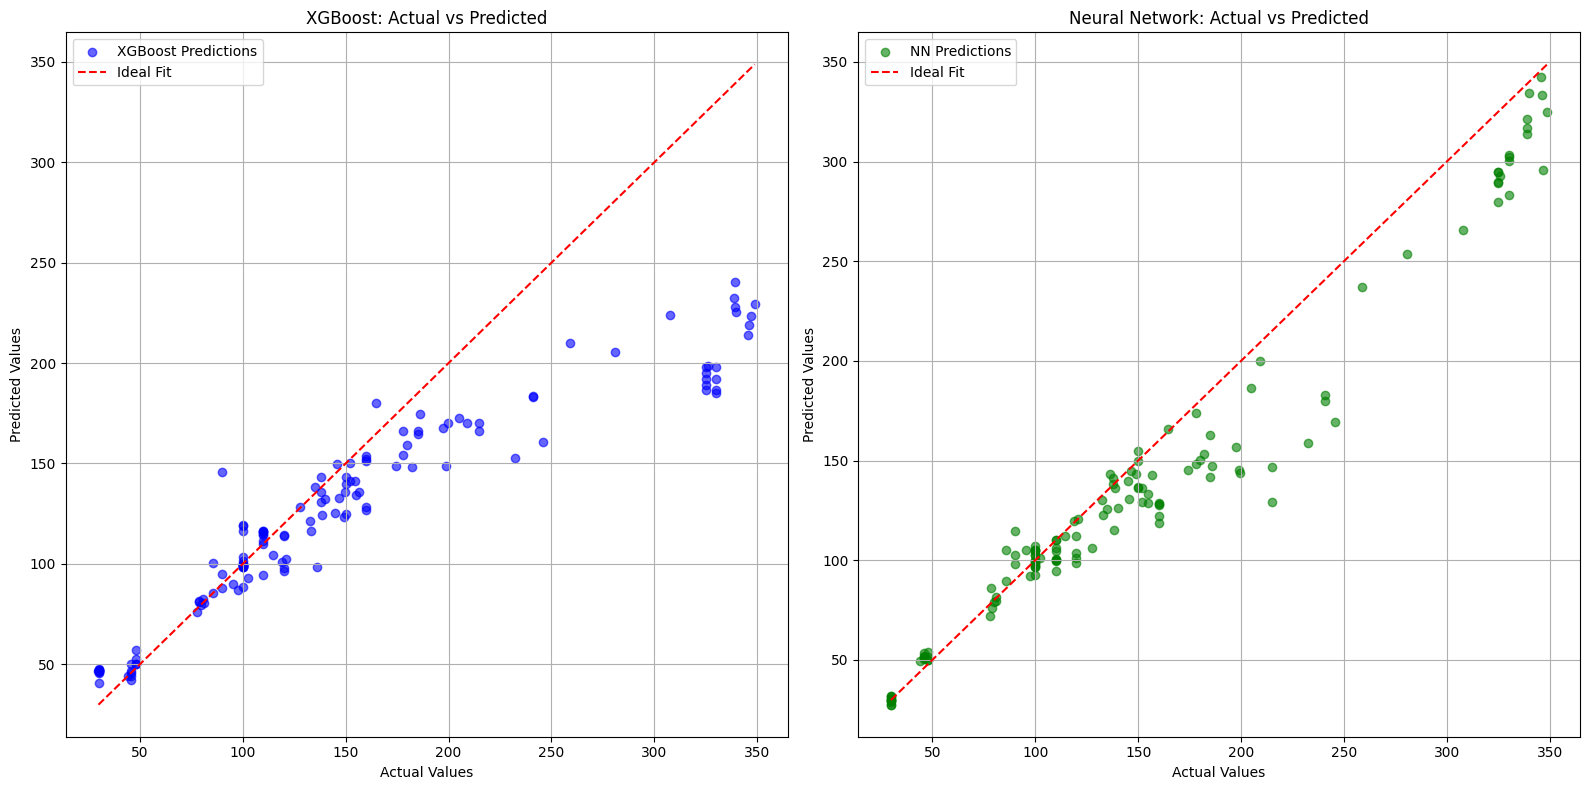

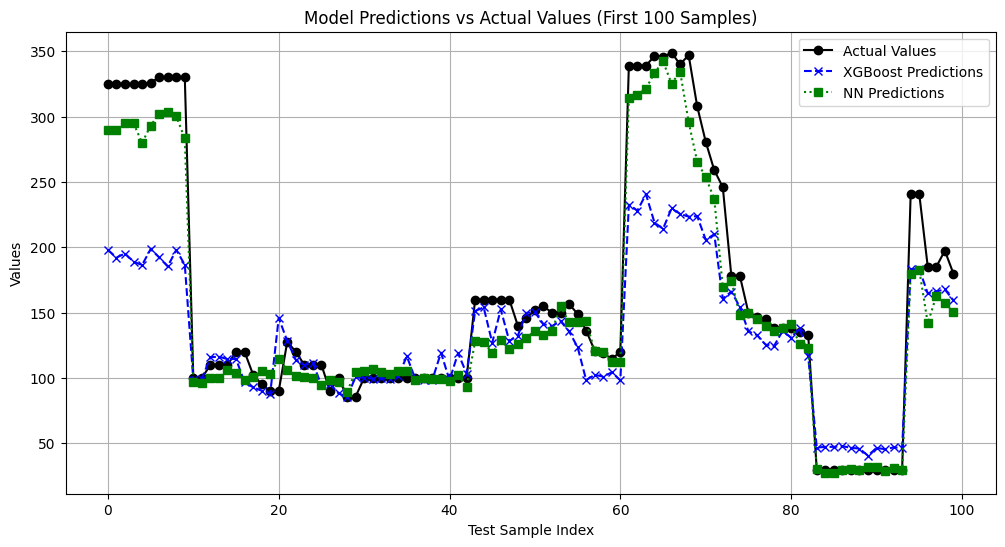

In [45]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test)
y_test_pred_nn = best_nn_model.predict(X_test).flatten()

# Plot the real vs. predicted values for both models
plt.figure(figsize=(16, 8))

# Subplot 1: XGBoost
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='blue', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.grid()

# Subplot 2: Neural Network
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_nn, alpha=0.6, color='green', label='NN Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Actual vs Predicted')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Combined Line Chart for Model Performance
plt.figure(figsize=(12, 6))

plt.plot(y_test.values[:100], label="Actual Values", marker='o', linestyle='-', color='black')
plt.plot(y_test_pred_xgb[:100], label="XGBoost Predictions", marker='x', linestyle='--', color='blue')
plt.plot(y_test_pred_nn[:100], label="NN Predictions", marker='s', linestyle=':', color='green')

plt.xlabel('Test Sample Index')
plt.ylabel('Values')
plt.title('Model Predictions vs Actual Values (First 100 Samples)')
plt.legend()
plt.grid()
plt.show()
